## **Bài tập thu thập dữ liệu (trang tĩnh/động/API)**

- Họ tên: Trần Hoàng Anh Phi
- MSSV: 20120158

Cập nhật ngày 20, 21/4/2023 update trường hợp các chuyến bay hết chỗ và lấy được toàn bộ muibox.

<font color=red>Nội dung:</font> 
- Thu thập dữ liệu giá vé máy bay trong các ngày gần nhất ở trang: <href>https://www.vietjetair.com/vi/</href> 
- Tìm giá vé nhỏ nhất từ dữ liệu đã thu thập

##### **Install các package cần thiết**

In [16]:
# %pip install selenium
# %pip install webdriver-manager
# %pip install beautifulsoup4
# %pip install lxml

##### **Import các thư viện**

In [17]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import re # Regular expressionc
from datetime import date, timedelta
from time import sleep
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import ElementNotInteractableException

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### **Dùng selenium để thực hiện thao tác đến trang xem giá vé** 

In [18]:
# Mở Chrome và cho full màn hình
# Tự tải phiên bản ChromeDriver phù hợp với phiên bản trên máy
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install())) #webdriver.Chrome("chromedriver.exe")
browser.maximize_window()
# Set thời gian chờ mặc định là 10 giây
browser.implicitly_wait(10)
# Mở trang chủ của Vietjet
url = 'https://www.vietjetair.com'
browser.get(url)

wait = WebDriverWait(browser, 10)

# Tắt quảng cáo 
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]'))).click()

# Chọn sử dụng cookie
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@class="MuiTypography-root jss140 jss154 MuiTypography-h5 MuiTypography-colorTextPrimary"]'))).click()

# Chọn vé một chiều
wait.until(EC.element_to_be_clickable((
    By.XPATH, '//span[contains(text(),"Một chiều")]'))).click()

# Chọn điểm khởi hành là TP HCM 
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@class="MuiInputBase-input MuiOutlinedInput-input"]'))).click()
# selectOrigin = browser.find_element(By.XPATH, '//*[@class="MuiInputBase-input MuiOutlinedInput-input"]')
# selectOrigin.click()
# sleep(3)

# Chọn sân bay Tân Sơn Nhất
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Tân Sơn Nhất")]'))).click()

# Chọn sân bay Đà Nẵng
try:
    wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Đà Nẵng")]'))).click()
except:
    wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Đà Nẵng")]'))).click()
    
# Chọn ngày tháng 
today = date.today()
tomorrow = today + timedelta(1)
tomorrow_year = str(tomorrow.year)
tomorrow_month = tomorrow.strftime('%m')
tomorrow_day = str(tomorrow.day)


# Chuỗi ngày tháng để click
str_time = 'tháng '+ tomorrow_month + ' ' + tomorrow_year 

wait.until(EC.presence_of_element_located((
    By.XPATH, '//*[contains(text(),"{a}")]//following-sibling::div[2]//descendant::span[contains(text(),"{b}")]'.format(a = str_time, b = tomorrow_day)))).click()

# Click Tìm chuyến bay
submit = wait.until(EC.visibility_of_element_located((By.XPATH, '(//*[contains(text(), "Tìm chuyến bay")])[2]'))) 
try: 
    submit.click()
except:
    submit.click()




##### **Bắt đầu crawl dữ liệu**
- Thư viện lxml để xử lý html lấy về từ browser
- Dùng xpath để trích xuất các thông tin cần thiết
- Sử dụng <code>**Beautifulsoup**</code> để lấy <code>class</code> "slick-track" chứa các thẻ có thông tin ngày bay. Sau đó ta lấy child là các thẻ con của thẻ này và dùng 
<code>**Selenium**</code> để lần lượt <code>click</code> và lấy dữ liệu.
- Mỗi khi click đến một ngày mới, ta lấy xpath root (chứa thông tin của các chuyến bay trong ngày) và lần lượt click vào từng row ( chuyến bay) để lấy các thông tin. Ở đây em dùng phương thức `html.fromstring` để lấy đối tượng html từ `page_source` mà browser trả về, sau đó truyền vào xpath và phương thức `text()` ở cuối để lấy text. Cuối cùng ta append vào list `data`.

In [19]:
from lxml import html
# Chọn số ngày cần lấy dữ liệu
nums_date = 12
tree = BeautifulSoup(browser.page_source, 'html.parser')

def find_by_xpath(element_source,xpath_expression):
    try: 
        root = html.fromstring(element_source)
        return root.xpath(xpath_expression) 
    except:
        return []

def check_seat(browser, rows, type, i): # kiểm tra xem còn chỗ hay không: type = hạng vé (tương ứng là 1, 2, 3, 4 )
    check = browser.find_element(By.XPATH, rows + f'[{i+1}]/div/div/div[2]/div[{type}]//p[contains(text(), "Hết chỗ")]')
    try: 
        if check: # Nếu hết chỗ thì return về xpath tương ứng
            return rows + f'[{i+1}]/div/div/div[2]/div[{type}]/div//p/text()'
    except: return rows + f'[{i+1}]/div/div/div[2]/div[{type}]/div/p[1]/text()'

def click_with_js(element):
    """Clicks an element using JavaScript"""
    browser.execute_script("arguments[0].click();", element)
    

class display_to_be_flex(object):
    """An expectation for checking that an element's display property has been changed to 'flex'."""
    def __init__(self, locator):
        self.locator = locator

    def __call__(self, driver):
        try:
            element = EC.presence_of_element_located(self.locator)(driver)
            if driver.execute_script("return getComputedStyle(arguments[0]).display;", element) == "flex":
                return element
            else:
                return False
        except StaleElementReferenceException:
            return False


data = []
root = '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'
def get_rows(browser, addr):
    sleep(1)
    # chờ để thông tin các chuyến bay được load đầy đủ và hiển thị trong css
    wait.until(display_to_be_flex((By.XPATH, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[2]')))
    wait.until(EC.visibility_of_all_elements_located((By.XPATH, root)))
    # browser.execute_script("document.querySelector('#my-button').click();")
    
    # scroll xuống cuối trang để thấy hết các muibox element
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(1)
    # scroll lại lên đầu trang để bắt đầu crawl
    browser.execute_script("window.scrollTo(0, 0)")
    n_rows = len(find_by_xpath(browser.page_source, root))
    print(n_rows)
    for i in range(n_rows):
        print(i, end = ' ')
        click = True
        
        ID = find_by_xpath(browser.page_source, 
                        root + f'[{i+1}]/div/div/div[1]/div[1]/span/span/text()')[0]
        
        # Thay đổi xpath để lấy text đúng trong trường hợp hết chỗ: div/p[1]/text() -> div//p//text()
        skyBoss_business = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[1]/div//p//text()')[0]
        skyBoss = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[2]/div//p//text()')[0]
        Deluxe = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[3]/div//p//text()')[0]
        Eco = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[4]/div//p//text()')[0]
        if skyBoss_business == skyBoss == Deluxe == Eco == 'Hết chỗ':
            click = False
        
        row_elem = wait.until(EC.element_to_be_clickable((By.XPATH, root + f'[{i+1}]/div/div[1]/div[1]')))
        if click:
            click_with_js(row_elem)
        sleep(0.01)
        
        # scroll tới ô cần click
        # browser.execute_script('return arguments[0].scrollIntoView(true);',
        #                        wait.until(EC.element_to_be_clickable((By.XPATH, rows + f'[{i+1}]/div/div[1]/div[1]'))))
        
        
        # scroll tới ô hiện ra thông tin
        print('click = ', click)
        if click:
            browser.execute_script('return arguments[0].scrollIntoView(true);',
                           wait.until(EC.element_to_be_clickable((By.XPATH, root + f'[{i+1}]/div/div[2]'))))
        else: 
            pass
        
        hours = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[1]/div[2]/text()')
        date = find_by_xpath(browser.page_source, addr + '/div/div/div/p[2]/text()')[0]
        
        
        
        start_ = find_by_xpath(browser.page_source, root + 
    f'[{i+1}]/div/div[2]/div/div/div/div/div/div/div[2]/div/div[1]/div/div[2]/p[1][1]/text()')[0] if click else hours[0][:-1] + ' ' + date
        end_ = find_by_xpath(browser.page_source, root + 
    f'[{i+1}]/div/div[2]/div/div/div/div/div/div/div[2]/div/div[2]/div/div[2]/p[1][1]/text()')[0] if click else hours[1][1:] + ' ' + date
        airbus = ''.join(element for element in find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[1]/div[3]/span/text()'))
        # wait.until(EC.presence_of_element_located((By.XPATH, root + f'[{i+1}]/div/div[1]/div[1]'))).click()
        data.append({'Số hiệu chuyến bay': ID, 'Khởi hành': start_, 'Đến': end_,'Airbus':airbus,
                     'SkyBOSS_Business':skyBoss_business, 'SkyBOSS': skyBoss, 'Deluxe': Deluxe, 'Eco': Eco})
        if click:
            click_with_js(row_elem)
        
    print('Đã load xong...\n')
    # scroll lên đầu trang để chuyển qua ngày khác
    browser.find_element(By.TAG_NAME, "body").send_keys(Keys.CONTROL + Keys.HOME)
    return data

slick_track = tree.find("div", class_="slick-track") 
count = 0
rows = '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'
for child in list(slick_track.children)[:nums_date]:
    # print(f'{(int(child.attrs["data-index"])+1)*"."}')
    sleep(1)
    # browser.execute_script("window.scrollTo(0,0);")
    addr = f'//*[@data-index="{int(child.attrs["data-index"])}"]'
    next_day = wait.until(EC.element_to_be_clickable((By.XPATH, f'//*[@data-index="{int(child.attrs["data-index"])}"]')))
    try: next_day.click()
    except: next_day.click()
    
    # print(len(find_by_xpath(browser.page_source, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div')))
    count += len(find_by_xpath(browser.page_source, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'))
    # get_rows_selenium(browser)
    get_rows(browser, addr)
print('Tổng số chuyến bay: ', count)

4
0 click =  True
1 click =  True
2 click =  True
3 click =  True
Đã load xong...

9
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
Đã load xong...

9
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
Đã load xong...

9
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
Đã load xong...

9
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
Đã load xong...

10
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
9 click =  True
Đã load xong...

10
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 

*Đánh giá: Vì sử dụng kết hợp giữa selenium và lxml nên tốc độ crawl tương đối chậm, chỉ hoạt động tốt ở những dữ liệu nhỏ và vừa (khoảng dưới 20 ngày)*

##### **Tiền xử lý dữ liệu**

In [39]:
flight = pd.DataFrame(data)
display(flight)

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
0,VJ634,"16:05, 21/04/2023 (Giờ địa phương)","17:25, 21/04/2023 (Giờ địa phương)",Airbus A320,Hết chỗ,"2,338","1,829","1,379"
1,VJ636,"18:20, 21/04/2023 (Giờ địa phương)","19:40, 21/04/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338","1,219",869
2,VJ638,"19:45, 21/04/2023 (Giờ địa phương)","21:05, 21/04/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",989,699
3,VJ640,"20:35, 21/04/2023 (Giờ địa phương)","21:50, 21/04/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,838","2,120","1,655"
4,VJ620,"05:35, 22/04/2023 (Giờ địa phương)","06:55, 22/04/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",549,299
...,...,...,...,...,...,...,...,...
113,VJ634,"16:05, 02/05/2023 (Giờ địa phương)","17:25, 02/05/2023 (Giờ địa phương)",Airbus A320,Hết chỗ,"2,838",549,299
114,VJ636,"18:20, 02/05/2023 (Giờ địa phương)","19:40, 02/05/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",340,190
115,VJ638,"19:45, 02/05/2023 (Giờ địa phương)","21:05, 02/05/2023 (Giờ địa phương)",Airbus A320,Hết chỗ,"2,838",340,190
116,VJ640,"20:35, 02/05/2023 (Giờ địa phương)","21:50, 02/05/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",340,190


In [40]:
flight.shape

(118, 8)

In [41]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Số hiệu chuyến bay  118 non-null    object
 1   Khởi hành           118 non-null    object
 2   Đến                 118 non-null    object
 3   Airbus              118 non-null    object
 4   SkyBOSS_Business    118 non-null    object
 5   SkyBOSS             118 non-null    object
 6   Deluxe              118 non-null    object
 7   Eco                 118 non-null    object
dtypes: object(8)
memory usage: 7.5+ KB


Dữ liệu gồm có 8 cột

Các cột `Số hiệu chuyến bay`, `Airbus` có kiểu dữ liệu là object tương đối phù hợp nên không cần thay đổi.

**Ta thấy các cột giá vé của các hạng vé phải có kiểu dữ liệu là numeric nhưng ở trên thể hiện kiểu dữ liệu object** 

Thử nhìn qua các giá trị của từng cột:

In [42]:
ticket_class = ['SkyBOSS_Business', 'SkyBOSS', 'Deluxe', 'Eco']
for i in ticket_class:
    print(flight[i].nunique(), flight[i].unique())

1 ['Hết chỗ']
3 ['2,338' '2,838' 'Hết chỗ']
17 ['1,829' '1,219' '989' '2,120' '549' '629' '1,069' '909' '789' '340' '709'
 '1,299' '1,509' '1,939' 'Hết chỗ' '1,619' '200']
17 ['1,379' '869' '699' '1,655' '299' '379' '779' '619' '539' '190' '459'
 '949' '1,159' '1,489' 'Hết chỗ' '1,269' '20']


Chuyển kiểu dữ liệu thành float

In [43]:
for i in ticket_class:
    flight[i] = flight[i].apply(lambda x: np.nan if x =='Hết chỗ' else x.replace(',', '') + 'e3').astype(float)

flight[ticket_class].dtypes

SkyBOSS_Business    float64
SkyBOSS             float64
Deluxe              float64
Eco                 float64
dtype: object

In [44]:
flight.isna().sum()

Số hiệu chuyến bay      0
Khởi hành               0
Đến                     0
Airbus                  0
SkyBOSS_Business      118
SkyBOSS                 7
Deluxe                  7
Eco                     7
dtype: int64

**Ta thấy cột Khởi hành và Đến có kiểu dữ liệu là object, ở đây ta sẽ đổi thành kiểu datetime cho phù hợp**

In [45]:
flight['Khởi hành']

0      16:05, 21/04/2023 (Giờ địa phương)
1      18:20, 21/04/2023 (Giờ địa phương)
2      19:45, 21/04/2023 (Giờ địa phương)
3      20:35, 21/04/2023 (Giờ địa phương)
4      05:35, 22/04/2023 (Giờ địa phương)
                      ...                
113    16:05, 02/05/2023 (Giờ địa phương)
114    18:20, 02/05/2023 (Giờ địa phương)
115    19:45, 02/05/2023 (Giờ địa phương)
116    20:35, 02/05/2023 (Giờ địa phương)
117    21:10, 02/05/2023 (Giờ địa phương)
Name: Khởi hành, Length: 118, dtype: object

In [46]:
import re 
pattern = r'(\d{1,2})\s+tháng\s+(\d{1,2})'
flight['Khởi hành'] = flight['Khởi hành'].str.replace('( \(Giờ địa phương\))', '').str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023").str.replace(',', '')
flight['Đến'] = flight['Đến'].str.replace('( \(Giờ địa phương\))', '').str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023").str.replace(',', '')

C:\Users\Admin\AppData\Local\Temp\ipykernel_11616\1264519487.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  flight['Khởi hành'] = flight['Khởi hành'].str.replace('( \(Giờ địa phương\))', '').str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023").str.replace(',', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_11616\1264519487.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  flight['Đến'] = flight['Đến'].str.replace('( \(Giờ địa phương\))', '').str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023").str.replace(',', '')


In [47]:
flight['Khởi hành']
str_time = '%H:%M %d/%m/%Y'
flight['Khởi hành'] = pd.to_datetime(flight['Khởi hành'], format=str_time)
flight['Đến'] = pd.to_datetime(flight['Đến'], format=str_time)
flight[['Khởi hành', 'Đến']].dtypes

Khởi hành    datetime64[ns]
Đến          datetime64[ns]
dtype: object

**Lưu vào file csv với filename là ngày lấy dữ liệu**

In [48]:
flight.to_csv(today.strftime('%d') + today.strftime('%m')+ today.strftime('%Y') + '.csv')

<font color=green>**Tìm giá vé rẻ nhất cho từng hạng vé**</font> 

In [49]:
# print('Vé rẻ nhất trong 10 ngày tới', flight.loc[flight['SkyBOSS'].idxmin()], sep='\n')
# print('Vé đắt nhất trong 10 ngày tới', flight.loc[flight['Deluxe'].idxmax()], sep='\n')
def min_price(class_):
    return flight[flight[class_] == flight[class_].min()]

display(min_price('SkyBOSS'))
display(min_price('Deluxe'))
display(min_price('Eco'))

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
0,VJ634,2023-04-21 16:05:00,2023-04-21 17:25:00,Airbus A320,NaN,2338000.0,1829000.0,1379000.0
1,VJ636,2023-04-21 18:20:00,2023-04-21 19:40:00,Airbus A321,NaN,2338000.0,1219000.0,869000.0
2,VJ638,2023-04-21 19:45:00,2023-04-21 21:05:00,Airbus A321,NaN,2338000.0,989000.0,699000.0
4,VJ620,2023-04-22 05:35:00,2023-04-22 06:55:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
5,VJ622,2023-04-22 07:05:00,2023-04-22 08:25:00,Airbus A321,NaN,2338000.0,629000.0,379000.0
...,...,...,...,...,...,...,...,...
111,VJ630,2023-05-02 13:35:00,2023-05-02 14:55:00,Airbus A321,NaN,2338000.0,629000.0,379000.0
112,VJ632,2023-05-02 15:40:00,2023-05-02 17:00:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
114,VJ636,2023-05-02 18:20:00,2023-05-02 19:40:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
116,VJ640,2023-05-02 20:35:00,2023-05-02 21:50:00,Airbus A321,NaN,2338000.0,340000.0,190000.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
104,VJ640,2023-05-01 20:35:00,2023-05-01 21:50:00,Airbus A321,NaN,2338000.0,200000.0,20000.0
105,VJ644,2023-05-01 21:10:00,2023-05-01 22:30:00,Airbus A321,NaN,2338000.0,200000.0,20000.0
106,VJ620,2023-05-02 05:35:00,2023-05-02 06:55:00,Airbus A321,NaN,2338000.0,200000.0,20000.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
104,VJ640,2023-05-01 20:35:00,2023-05-01 21:50:00,Airbus A321,NaN,2338000.0,200000.0,20000.0
105,VJ644,2023-05-01 21:10:00,2023-05-01 22:30:00,Airbus A321,NaN,2338000.0,200000.0,20000.0
106,VJ620,2023-05-02 05:35:00,2023-05-02 06:55:00,Airbus A321,NaN,2338000.0,200000.0,20000.0


<font color=green>**Tìm giá vé rẻ nhất của mỗi ngày cho từng hạng vé**</font>

In [50]:
def min_price_date(class_):
    choose = flight['Khởi hành'].dt.strftime('%d/%m')
    mask = flight.groupby(choose)[class_].transform('min') == flight[class_]
    return flight[mask].sort_values(by='Khởi hành')

display(min_price_date('SkyBOSS'))
display(min_price_date('Deluxe'))
display(min_price_date('Eco'))

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
0,VJ634,2023-04-21 16:05:00,2023-04-21 17:25:00,Airbus A320,NaN,2338000.0,1829000.0,1379000.0
1,VJ636,2023-04-21 18:20:00,2023-04-21 19:40:00,Airbus A321,NaN,2338000.0,1219000.0,869000.0
2,VJ638,2023-04-21 19:45:00,2023-04-21 21:05:00,Airbus A321,NaN,2338000.0,989000.0,699000.0
4,VJ620,2023-04-22 05:35:00,2023-04-22 06:55:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
5,VJ622,2023-04-22 07:05:00,2023-04-22 08:25:00,Airbus A321,NaN,2338000.0,629000.0,379000.0
...,...,...,...,...,...,...,...,...
111,VJ630,2023-05-02 13:35:00,2023-05-02 14:55:00,Airbus A321,NaN,2338000.0,629000.0,379000.0
112,VJ632,2023-05-02 15:40:00,2023-05-02 17:00:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
114,VJ636,2023-05-02 18:20:00,2023-05-02 19:40:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
116,VJ640,2023-05-02 20:35:00,2023-05-02 21:50:00,Airbus A321,NaN,2338000.0,340000.0,190000.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
2,VJ638,2023-04-21 19:45:00,2023-04-21 21:05:00,Airbus A321,NaN,2338000.0,989000.0,699000.0
4,VJ620,2023-04-22 05:35:00,2023-04-22 06:55:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
12,VJ640,2023-04-22 20:35:00,2023-04-22 21:50:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
20,VJ638,2023-04-23 19:45:00,2023-04-23 21:05:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
22,VJ620,2023-04-24 05:35:00,2023-04-24 06:55:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
26,VJ632,2023-04-24 15:40:00,2023-04-24 17:00:00,Airbus A320,NaN,2338000.0,340000.0,190000.0
27,VJ634,2023-04-24 16:05:00,2023-04-24 17:25:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
28,VJ636,2023-04-24 18:20:00,2023-04-24 19:40:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
29,VJ638,2023-04-24 19:45:00,2023-04-24 21:05:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
30,VJ640,2023-04-24 20:35:00,2023-04-24 21:50:00,Airbus A321,NaN,2338000.0,340000.0,190000.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
2,VJ638,2023-04-21 19:45:00,2023-04-21 21:05:00,Airbus A321,NaN,2338000.0,989000.0,699000.0
4,VJ620,2023-04-22 05:35:00,2023-04-22 06:55:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
12,VJ640,2023-04-22 20:35:00,2023-04-22 21:50:00,Airbus A321,NaN,2338000.0,549000.0,299000.0
20,VJ638,2023-04-23 19:45:00,2023-04-23 21:05:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
22,VJ620,2023-04-24 05:35:00,2023-04-24 06:55:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
26,VJ632,2023-04-24 15:40:00,2023-04-24 17:00:00,Airbus A320,NaN,2338000.0,340000.0,190000.0
27,VJ634,2023-04-24 16:05:00,2023-04-24 17:25:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
28,VJ636,2023-04-24 18:20:00,2023-04-24 19:40:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
29,VJ638,2023-04-24 19:45:00,2023-04-24 21:05:00,Airbus A321,NaN,2338000.0,340000.0,190000.0
30,VJ640,2023-04-24 20:35:00,2023-04-24 21:50:00,Airbus A321,NaN,2338000.0,340000.0,190000.0


#### **Trực quan hoá dữ liệu**

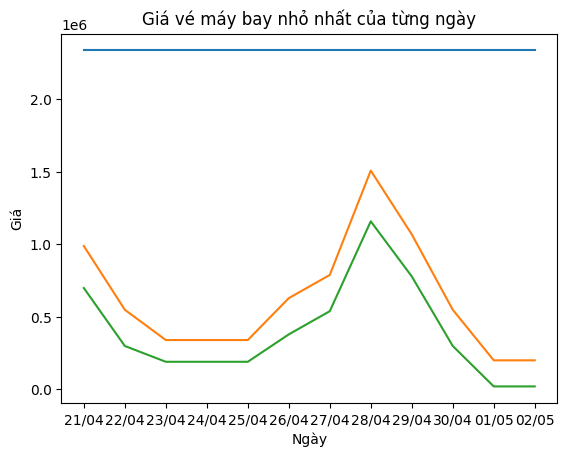

In [51]:
def plot_price(class_):
    min_df = min_price_date(class_)
    min_df['date'] = min_df['Khởi hành'].dt.strftime('%d/%m')
    plt.plot(min_df['date'], min_df[class_])
    plt.title('Giá vé máy bay nhỏ nhất của từng ngày')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')

plot_price('SkyBOSS')
plot_price('Deluxe')
plot_price('Eco')

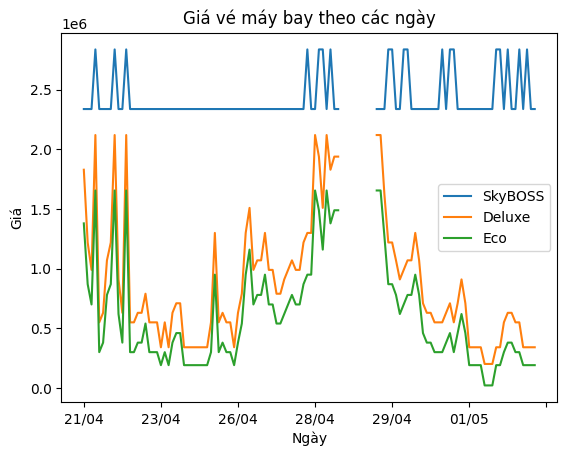

In [57]:
flight[ticket_class[1:]].set_index(flight['Khởi hành'].dt.strftime('%d/%m')).plot()
plt.title('Giá vé máy bay theo các ngày')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.savefig('giave.png')